# Movie Success Predictor

This project uses machine learning to predict whether a movie will be a **Hit** or **Flop**, and also to estimate its **Box Office Revenue** based on features like budget, runtime, cast, genres, and director.

**Models Used:**
- Linear Regression for revenue prediction
- Random Forest Classifier for hit/flop classification

**Dataset:** [TMDB 5000 Movie Dataset](https://www.kaggle.com/datasets/tmdb/tmdb-movie-metadata)


In [37]:
import pandas as pd
import numpy as np
import json
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")


In [38]:
# Load datasets
movies_df = pd.read_csv("tmdb_5000_movies.csv")
credits_df = pd.read_csv("tmdb_5000_credits.csv")

In [39]:

# Merge datasets on 'id'
credits_df.rename(columns={'movie_id': 'id'}, inplace=True)
df = movies_df.merge(credits_df, on='id')
df.head()

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,...,runtime,spoken_languages,status,tagline,title_x,vote_average,vote_count,title_y,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...",...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...",...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...",...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...",...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]",...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


In [40]:
movies_df

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4798,220000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",NaN,9367,"[{""id"": 5616, ""name"": ""united states\u2013mexi...",es,El Mariachi,El Mariachi just wants to play his guitar and ...,14.269792,"[{""name"": ""Columbia Pictures"", ""id"": 5}]","[{""iso_3166_1"": ""MX"", ""name"": ""Mexico""}, {""iso...",1992-09-04,2040920,81.0,"[{""iso_639_1"": ""es"", ""name"": ""Espa\u00f1ol""}]",Released,"He didn't come looking for trouble, but troubl...",El Mariachi,6.6,238
4799,9000,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 10749, ""...",NaN,72766,[],en,Newlyweds,A newlywed couple's honeymoon is upended by th...,0.642552,[],[],2011-12-26,0,85.0,[],Released,A newlywed couple's honeymoon is upended by th...,Newlyweds,5.9,5
4800,0,"[{""id"": 35, ""name"": ""Comedy""}, {""id"": 18, ""nam...",http://www.hallmarkchannel.com/signedsealeddel...,231617,"[{""id"": 248, ""name"": ""date""}, {""id"": 699, ""nam...",en,"Signed, Sealed, Delivered","""Signed, Sealed, Delivered"" introduces a dedic...",1.444476,"[{""name"": ""Front Street Pictures"", ""

In [41]:
credits_df

,id,title,cast,crew
0,19995,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,285,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,206647,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,49026,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,49529,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."
...,...,...,...,...
4798,9367,El Mariachi,"[{""cast_id"": 1, ""character"": ""El Mariachi"", ""c...","[{""credit_id"": ""52fe44eec3a36847f80b280b"", ""de..."
4799,72766,Newlyweds,"[{""cast_id"": 1, ""character"": ""Buzzy"", ""credit_...","[{""credit_id"": ""52fe487dc3a368484e0fb013"", ""de..."
4800,231617,"Signed, Sealed, Delivered","[{""cast_id"": 8, ""character"": ""Oliver O\u2019To...","[{""credit_id"": ""52fe4df3c3a36847f8275ecf"", ""de..."
4801,126186,Shanghai Calling,"[{""cast_id"": 3, ""character"": ""Sam"", ""credit_id...","[{""credit_id"": ""52fe4ad9c3a368484e16a36b"", ""de..."


In [42]:
# Parse JSON fields
def parse_json_column(column):
    return column.apply(lambda x: [i['name'] for i in json.loads(x)] if pd.notna(x) else [])

df['genres'] = parse_json_column(df['genres'])
df['cast'] = df['cast'].apply(lambda x: [i['name'] for i in json.loads(x)][:3] if pd.notna(x) else [])
df['crew'] = df['crew'].apply(lambda x: [i for i in json.loads(x)] if pd.notna(x) else [])
df['director'] = df['crew'].apply(lambda crew: next((member['name'] for member in crew if member['job'] == 'Director'), None))


In [43]:
df_model = df[['budget', 'revenue', 'runtime', 'genres', 'cast', 'director']].copy()
df_model.dropna(inplace=True)
df_model = df_model[(df_model['budget'] > 0) & (df_model['revenue'] > 0)]


In [44]:
# Define Hit or Flop
df_model['status'] = df_model.apply(lambda row: 'Hit' if row['revenue'] > 2 * row['budget'] else 'Flop', axis=1)

In [45]:
# Encode label
label_encoder = LabelEncoder()
df_model['status_encoded'] = label_encoder.fit_transform(df_model['status'])

In [46]:
# Join genres and cast into strings
df_model['genres'] = df_model['genres'].apply(lambda x: ' '.join(x))
df_model['cast'] = df_model['cast'].apply(lambda x: ' '.join(x))
df_model['director'] = df_model['director'].fillna('')

In [47]:
# Define features and targets
X = df_model[['budget', 'runtime', 'genres', 'cast', 'director']]
y_reg = df_model['revenue']
y_clf = df_model['status_encoded']


In [48]:
# Column Transformer
categorical_features = ['genres', 'cast', 'director']
preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
], remainder='passthrough')

In [49]:
# Regression
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_reg, test_size=0.2, random_state=42)
reg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

In [50]:
reg_pipeline.fit(X_train_r, y_train_r)
y_pred_r = reg_pipeline.predict(X_test_r)

In [51]:
# Classification
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X, y_clf, test_size=0.2, random_state=42)
clf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

In [52]:
clf_pipeline.fit(X_train_c, y_train_c)
y_pred_c = clf_pipeline.predict(X_test_c)

In [53]:
# Regression Evaluation
mse = mean_squared_error(y_test_r, y_pred_r)
r2 = r2_score(y_test_r, y_pred_r)
print("📈 Regression Metrics:")
print("Mean Squared Error:", mse)
print("R2 Score:", r2)


📈 Regression Metrics:
Mean Squared Error: 2.692668316147714e+16
R2 Score: 0.47800112331054967


In [54]:
# Classification Evaluation
print("\\n📊 Classification Metrics:")
print("Confusion Matrix:")
print(confusion_matrix(y_test_c, y_pred_c))
print("\\nClassification Report:")
print(classification_report(y_test_c, y_pred_c, target_names=label_encoder.classes_))

\n📊 Classification Metrics:
Confusion Matrix:
[[ 86 208]
 [ 63 289]]
\nClassification Report:
              precision    recall  f1-score   support

        Flop       0.58      0.29      0.39       294
         Hit       0.58      0.82      0.68       352

    accuracy                           0.58       646
   macro avg       0.58      0.56      0.53       646
weighted avg       0.58      0.58      0.55       646



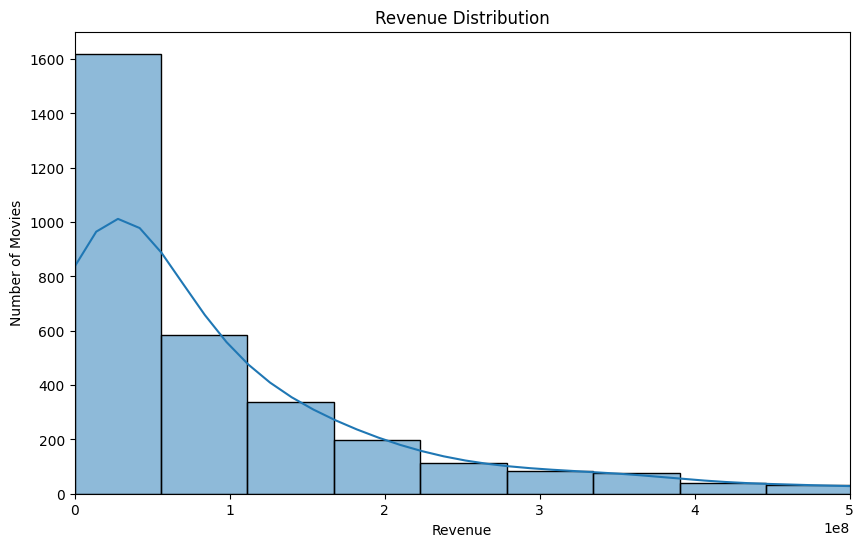

In [55]:
# Revenue Distribution
plt.figure(figsize=(10,6))
sns.histplot(df_model['revenue'], bins=50, kde=True)
plt.title("Revenue Distribution")
plt.xlabel("Revenue")
plt.ylabel("Number of Movies")
plt.xlim(0, 500_000_000)
plt.show()

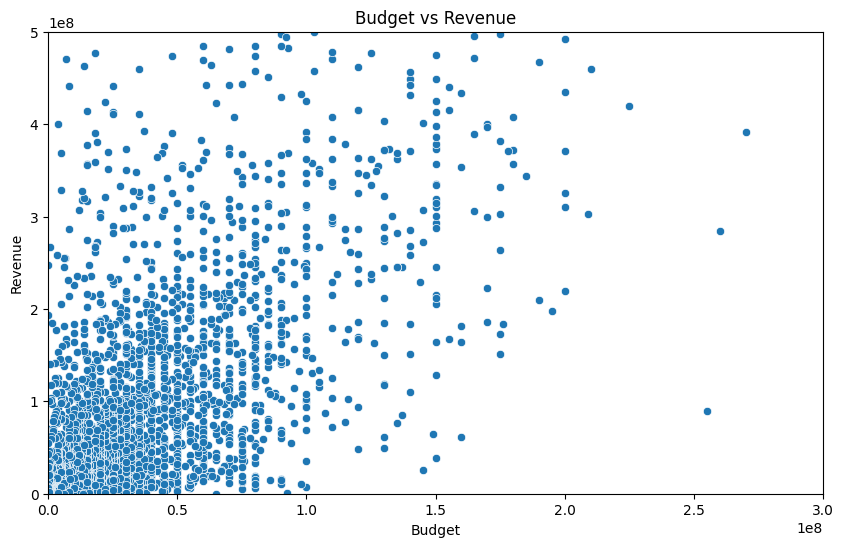

In [56]:
# Budget vs Revenue Scatter Plot
plt.figure(figsize=(10,6))
sns.scatterplot(x='budget', y='revenue', data=df_model)
plt.title("Budget vs Revenue")
plt.xlabel("Budget")
plt.ylabel("Revenue")
plt.xlim(0, 300_000_000)
plt.ylim(0, 500_000_000)
plt.show()

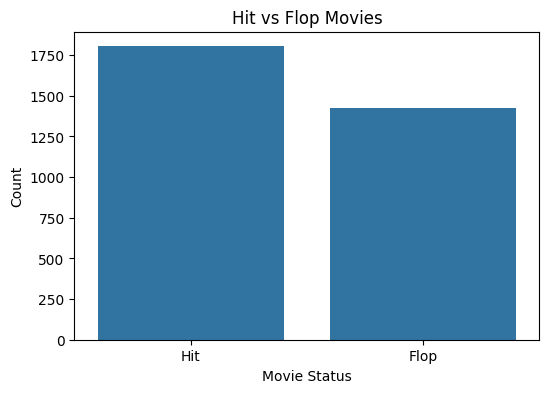

In [57]:
# Hit vs Flop Count
plt.figure(figsize=(6,4))
sns.countplot(x='status', data=df_model)
plt.title("Hit vs Flop Movies")
plt.xlabel("Movie Status")
plt.ylabel("Count")
plt.show()

In [60]:
# ✅ Define the function
def predict_movie_outcome(movie_name):
    try:
        movie = df[df['original_title'].str.lower() == movie_name.strip().lower()]
        
        if movie.empty:
            return f"❌ Movie '{movie_name}' not found in the dataset."
        
        # Prepare features
        movie_features = movie[['budget', 'runtime', 'genres', 'cast', 'director']].copy()
        movie_features['genres'] = movie_features['genres'].apply(lambda x: ' '.join(x))
        movie_features['cast'] = movie_features['cast'].apply(lambda x: ' '.join(x))
        movie_features['director'] = movie_features['director'].fillna('')
        
        # Predict revenue
        predicted_revenue = reg_pipeline.predict(movie_features)[0]
        
        # Predict hit/flop
        predicted_status_encoded = clf_pipeline.predict(movie_features)[0]
        predicted_status = label_encoder.inverse_transform([predicted_status_encoded])[0]
        
        return f"""
🎬 Movie: {movie_name.title()}
💰 Predicted Revenue: ${predicted_revenue:,.2f}
📊 Prediction: {predicted_status}
        """
    except Exception as e:
        return f"⚠️ Error: {e}"

In [59]:
# Ask for input in Jupyter
movie_input = input("Enter the movie name for prediction: ")
print(predict_movie_outcome(movie_input))


🎬 Movie: John Carter
💰 Predicted Revenue: $749,043,751.66
📊 Prediction: Flop
        
